# Mean Shift 
## KDE(Kernel Density Estimation) 이용
- 비모수적 추론 방법

[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069   0.3190391  -0.24937038  1.46210794 -2.06014071
 -0.3224172  -0.38405435  1.13376944 -1.09989127 -0.17242821 -0.87785842
  0.04221375  0.58281521 -1.10061918  1.14472371  0.90159072  0.50249434
  0.90085595 -0.68372786 -0.12289023 -0.93576943 -0.26788808  0.53035547]


<AxesSubplot:>

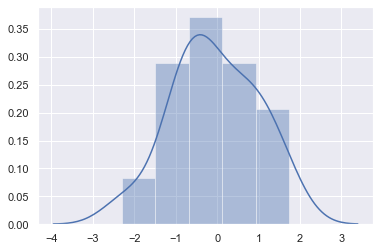

In [1]:
# seaborn에서 제공하는 distplot으로 KDE 시각화 가능
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

np.random.seed(1)
# 정규분포 데이터 만들기
x = np.random.normal(0, 1, size=30)
print(x)
sns.distplot(x)

- 실선으로 된 그래프가 KDE를 활용해 확률을 추정하여 그린 확률밀도함수

<AxesSubplot:>

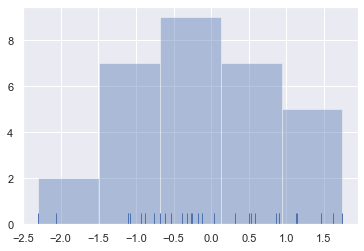

In [2]:
# rug인자를 추가해서 데이터값들이 어떤 확률분포에 많이 존재하는지 살펴보기 가능
sns.distplot(x, kde=False, rug=True)

<AxesSubplot:>

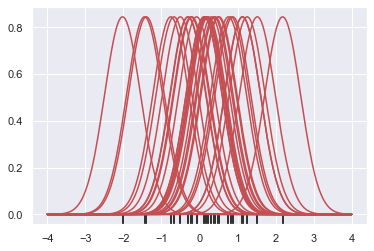

In [5]:
#개별 관측 데이터에 대해 가우시안 커널 함수 공식을 이용해 적용 후 시각화
from scipy import stats

#정규분포 데이터 만들기
x = np.random.normal(0, 1, size=30)
# KDE함수의 중요한 파라미터인 bandwith 생성 공식 이용
bandwidth = 1.06 * x.std() * x.size ** (-1/ 5.)
# 그래프의 x축(확률변수) 값 범위 지정(-4~4까지 200개)
support = np.linspace(-4, 4, 200)

kernels = []
for x_i in x:
    #각 확률변수(각 데이터)에 대해 확률 추정
    kernel = stats.norm(x_i, bandwidth).pdf(support)
    kernels.append(kernel)
    #각 데이터 마다 가우시안 커널 함수 그리기
    plt.plot(support, kernel, color='r')

sns.rugplot(x, color='.2', linewidth=2)

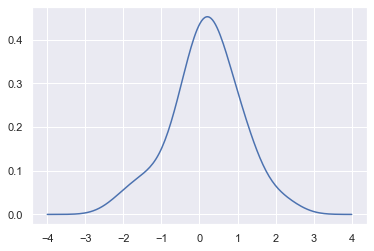

In [18]:
# 위에서 구한 개별 데이터의 가우시안 커널 함수를 합산하기
from scipy.integrate import trapz
# 확률밀도함수 합산
density = np.sum(kernels, axis=0)

# 합산한 것 개별 관측 데이터 개수로 나누기
# 할당연산자 '/=' 같은 것들은 연산자 양옆에 값이 할당된 '변수'가 있어야함!
density /= trapz(density, support)
plt.plot(support, density)

<AxesSubplot:>

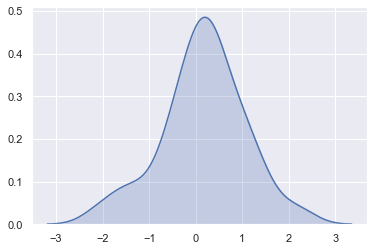

In [19]:
# seaborn의 kdeplot으로 KDE곡선 바로 구하기 가능
sns.kdeplot(x, shade=True)

- 중요 파라미터인 bandwidth는 값에 따라 오버피팅/언더피팅을 결정한다.
    * 값이 높을수록 적은 클러스터링을 구현하며 언더피팅 유발
    * 값이 작을수록 많은 클러스터링을 구현하며 오버피팅 유발

<AxesSubplot:>

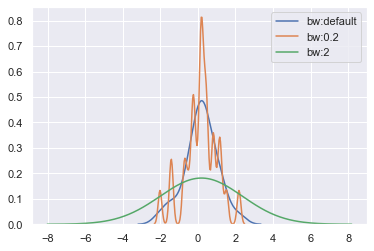

In [22]:
# bandwidth값에 따른 KDE변화 시각화
sns.kdeplot(x, label='bw:default')
# bw : bandwidth의미
sns.kdeplot(x, bw=0.1, label='bw:0.2')
sns.kdeplot(x, bw=2, label='bw:2')

## Sklearn - MeanShift API 사용

In [28]:
# 클러스터링용 데이터 생성
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift
# 2차원 feature와 label반환
X, y = make_blobs(n_samples=200, n_features=2, centers=3,
                 cluster_std=0.8, random_state=12)
meanshift = MeanShift(bandwidth=1.4)
# clustering 레이블 반환(이 레이블은 실제 y값 레이블과 수치적으로 동일매핑 아님!)
cluster_labels = meanshift.fit_predict(X)
print('Cluster Label 유형:',np.unique(cluster_labels))

Cluster Label 유형: [0 1 2]


In [29]:
# bandwidth의 적정값을 estimate_bandwidth함수로 출력 가능
from sklearn.cluster import estimate_bandwidth
# quantile : 데이터 개수의 일정 비율만큼 샘플링하면서 meanshift하게됨
# 따라서, 데이터 개수가 엄청 많아질시 quantile값이 적으면 시간이 너무 오래걸림
bandwidth = estimate_bandwidth(X, quantile=0.25)
print("최적의 bandwidth 값:", round(bandwidth, 3))

최적의 bandwidth 값: 1.771


In [32]:
# 최적의 bandwidth값으로 Meanshift 클러스터링
import pandas as pd

cluster_df = pd.DataFrame(data=X, columns=['ftr1','ftr2'])
cluster_df['target'] = y

best_bandwidth = estimate_bandwidth(X, quantile=0.25)
meanshift = MeanShift(round(best_bandwidth,2))
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass bandwidth=1.77 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


cluster labels 유형: [0 1 2]


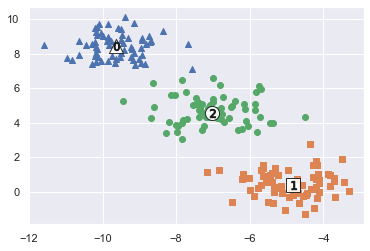

In [33]:
# MeanShift로 클러스터링한 후 중심 시각화
import matplotlib.pyplot as plt

cluster_df['meanshift_label'] = cluster_labels
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers = ['^','s','o','P']

for label in unique_labels:
    label_cluster = cluster_df[cluster_df['meanshift_label']==label]
    center_x_y = centers[label]
    # 데이터 시각화
    plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'],
               marker=markers[label])
    # 군집별 중심 시각화
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='white',
               edgecolor='k', alpha=0.9, marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',
               marker='$%d$' % label)
plt.show()

In [34]:
cluster_df.groupby('target')['meanshift_label'].value_counts()

target  meanshift_label
0       2                  66
        0                   1
1       1                  67
2       0                  65
        2                   1
Name: meanshift_label, dtype: int64